## Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus

# Part 3: Textual Analysis

In this notebook, we analyze the pre-processed output of our custom CoreNLP pipeline. 

### Table of contents

### Table of contents
1. [Loading pre-processed coreNLP data](#section1)
2. [Persona clusters](#section2)
    - 2.1. [Embedding descriptions](#section2-1)
    - 2.2. [Principal Component Analysis (PCA)](#section2-2)
    - 2.3. [Clustering personas](#section2-3)
    - 2.4. [Visualizing persona clusters](#section2-4)

**Prerequisite**: 

Install [spaCy](https://spacy.io) using the following commands: 

        pip install spacy
        
        python3 -m spacy download en_core_web_sm

In [73]:
import os
import pickle
import spacy
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

from extraction import *
from coreNLP_analysis import *
from load_data import *
from textual_analysis import *

# NOTE: If you haven't loaded NLTK before, set this to True
load_nltk = False

if load_nltk: #Load the spaCy model for the semantic analysis
    nlp_spacy = spacy.load("en_core_web_lg")

## 1. Load pre-processed coreNLP data <a class="anchor" id="section1"></a>

We first load the pre-processed output from our custom CoreNLP pipeline. 

In [13]:
descriptions, relations = load_descr_relations()

## 2. Persona clusters <a class="anchor" id="section2"></a>

### 2.1. Embedding descriptions <a class="anchor" id="section2-1"></a>

We embed all descriptive words (actions, attributes, titles) of all characters into a high-dimensional vector space using spaCy. 

In [77]:
pickle_file = 'Data/CoreNLP/char_description_embeddings.pickle'

# If we have already embedded the descriptions, load them from the pickle file
if os.path.exists(pickle_file):
    char_description_df = pd.read_pickle(pickle_file)

else:
    # Load description
    char_description_path = 'Data/CoreNLP/char_descriptions.csv'
    char_description_df = pd.read_csv(char_description_path, sep='\t', index_col=0)
    full_description_path = 'Data/CoreNLP/full_descriptions.csv'
    full_description_df = pd.read_csv(full_description_path, sep='\t', index_col=0)

    # Embed descriptions
    char_description_df['descriptions_embeddings'] = char_description_df['descriptions'].apply(
        embed_descriptions(nlp_spacy=nlp_spacy))
    
    # Save the embeddings to a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(char_description_df, f)

### 2.2. Principal Component Analysis (PCA) <a class="anchor" id="section2-2"></a>

We then map these high-dimensional descriptive vectors to 3-dimensional space so that we can visualize it as a point cloud. 

In [79]:
def descriptions_PCA(df, n_components=3):
    ''' Apply PCA to the embeddings of the descriptions and store the results in the dataframe.'''
    # From the column descriptions_embeddings, get a matrix with the embeddings of each character of size n x 300
    X = np.array(df['descriptions_embeddings'].tolist())
    X = X.reshape(X.shape[0], X.shape[2])

    # Now apply PCA to the matrix X
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)

    # Store the results in the dataframe
    df['pca_1'] = X_pca[:, 0]
    df['pca_2'] = X_pca[:, 1]
    df['pca_3'] = X_pca[:, 2]
    
    return df


In [80]:
char_description_df = descriptions_PCA(char_description_df, n_components=3)

### 2.3. Clustering personas <a class="anchor" id="section2-3"></a>

The persona point cloud is clustered into several categories. 

In [82]:
def cluster_descriptions(df, n_components): 
    ''' Perform clustering using gaussian mixture model, on the 3 principal components in the dataframe '''
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(df[['pca_1', 'pca_2', 'pca_3']])
    labels = gmm.predict(df[['pca_1', 'pca_2', 'pca_3']])
    df['labels'] = labels
    return df

In [83]:
# Remove the outlier on the pca_1 dimension
char_description_df = char_description_df[char_description_df['pca_1'] < 2]

# Cluster the descriptions
char_description_df = cluster_descriptions(char_description_df, n_components=8)

### 2.4. Visualizing persona clusters <a class="anchor" id="section2-4"></a>

The clustered persona point cloud is shown below. 

In [84]:
n_clusters = len(char_description_df['labels'].unique())
CMAP = plt.cm.get_cmap('viridis', n_clusters)


In [85]:
def plot_clusters_3d(df, title):
    ''' Plot the clusters in 3D '''
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['pca_1'], df['pca_2'], df['pca_3'], c=df['labels'], cmap=CMAP)
    ax.set_xlabel('pca_1')
    ax.set_ylabel('pca_2')
    ax.set_zlabel('pca_3')
    ax.set_xlim(df['pca_1'].min(), df['pca_1'].max())
    ax.set_ylim(df['pca_2'].min(), df['pca_2'].max())
    ax.set_zlim(df['pca_3'].min(), df['pca_3'].max())
    plt.title(title)
    plt.show()

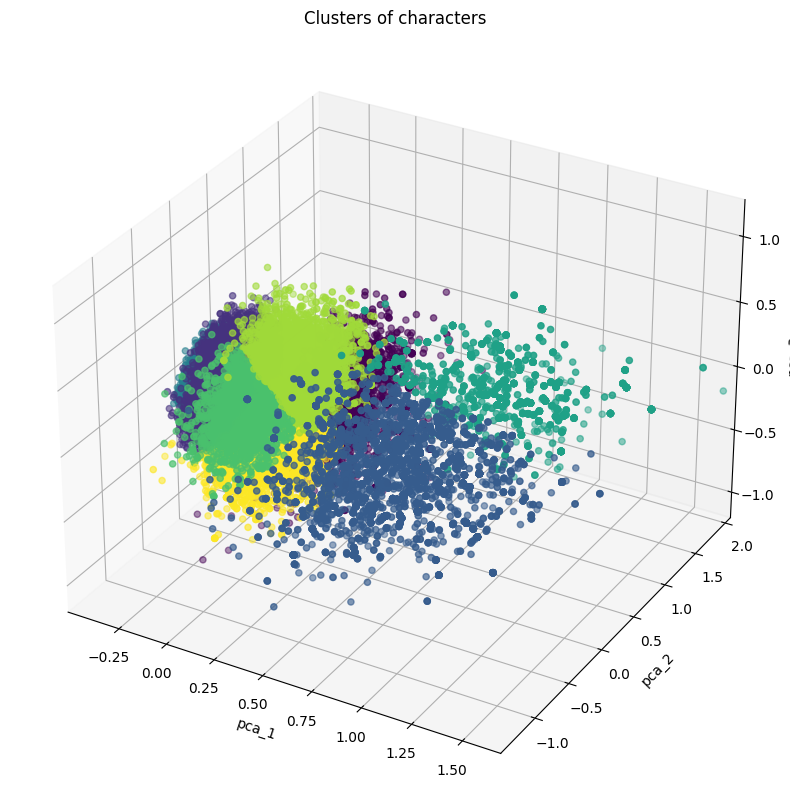

In [86]:
plot_clusters_3d(char_description_df, 'Clusters of characters')

**Experimenting with clusters**

We would like to give persona labels to all clusters. 

First, we remove all characters which have less than 10 descriptive words associated to them. 



In [87]:
# Get all characters which have more than 10 descriptive words in their description
num_words = 10
char_description_df['n_words'] = char_description_df['descriptions'].apply(lambda x: len(x.split()))
long_chars = char_description_df[char_description_df['n_words'] > num_words]

print(f'{len(long_chars)} out of {len(char_description_df)} characters have more than {num_words} descriptive words in their description.')

11262 out of 45068 characters have more than 10 descriptive words in their description.


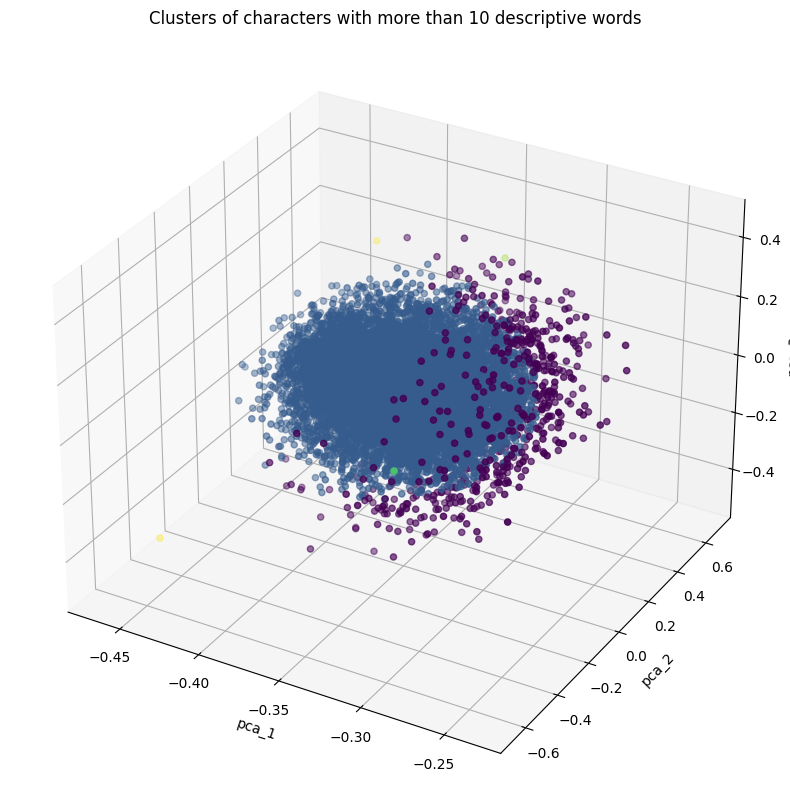

In [88]:
plot_clusters_3d(long_chars, 'Clusters of characters with more than 10 descriptive words')


NOTE: It would be nice to remove stopwords from the descriptions before running the embedding, because maybe the extra volume of generic words trumps out the averaging of the descriptive vectors. However, we'd have to rerun the whole embedding again. 


### All code from here should be revised

A stop word is a frequently used term that a search engine has been configured to ignore, both while indexing entries for searching and when retrieving them as the result of a search query. Examples of stop words include "the," "a," "an," and "in."
We don't want these terms to take up any unnecessary storage space or processing time in our database. By keeping a record of the terms you believe to be stop words, we may easily eliminate them for this reason.

In [ ]:
#Take random sample of 10% of the plot summaries
plot_df_sample = plot_df.sample(frac=0.1, random_state=1)

#copy the plot_df to a new dataframe
plot_df_removed = plot_df_sample.copy()

#Remove stopwords from the summaries
plot_df_removed['Summary'] = plot_df_sample['Summary'].apply(remove_stopwords)

### 2. Semantic scoring

The semantic scoring is done by using the [SpaCy](https://spacy.io/) library that has pretrained word vectors for our semantic scoring. We aim to assess whether a movie is romantic. We (somewhat arbitrarily) choose to find the similarity between a movie and the word "love". Spacy can calculate the cosine similarity between the vector representation of "love" and the vector representation of a plot summary. The cosine similarity is defined as:

$\text{cosine similarity}(x_1, x_2) = \frac{x_1 \cdot x_2}{||x_1||\cdot||x_2||}$

Where $x_1$ and $x_2$ are two vector representations of either a word or document. Spacy calculates the vector representation of a document as the average of the representations of its words.

The idea behind this method is that if a plot summary is semantically close to the word "love", it is likely to be a romantic movie. One has to be aware that this method has severe downsides. First, the word "love" is a somewhat arbitrary choice. A second downside will become apparent later on.

In [ ]:
#The reference word is the word that we want to find the similarity with
words = nlp_spacy("love")

#Create a column with the similarity score of the summaries to each word in words
for word in words:
        plot_df_removed[word.text] = np.nan
        plot_df_removed[word.text] = plot_df_removed['Summary'].apply(lambda x: nlp_spacy(' '.join(x)).similarity(words))

#sort the dataframe by the similarity score
plot_df_removed.sort_values(by='love', ascending=False, inplace=True)
plot_df_removed.head()


In [ ]:
#plot the similarity score of the summaries to the reference word
plot_df_removed['love'].plot(kind='hist', bins=100)
plt.ylabel('Frequency')
plt.xlabel('Similarity score to the word "love"')
plt.show()


### 3. Love words extraction

In the previous part of the analysis, we have given similarity scores to each plot summary, which reflect how semantically close a summary is to the word "love". Now, we have to set a threshold to classify words as love-related or not. This presents a second challenge for this method. Picking the optimal threshold is not trivial. A threshold that is too low will result in many unrelated words, whereas a threshold that is too high will result in a low recall of romantic movies. We will show this effect here, by presenting the results of three thresholds. With a threshold of 0.9, only the word 'love' is classified as love-related. At a threshold of 0.6, we see more good words popping up, like 'feel' and 'like'. However, already at this threshold there are some questionable words, like 'think' and 'thought'. At a threshold of 0.3, there are too many words of which many unrelated to love. 

In [ ]:
from textual_analysis import *
#The threshold is the minimum similarity score to be considered a love-related word
love_thresholds = [0.9, 0.6, 0.3]

for love_threshold in love_thresholds:
#Create a column with the love-related words in the summaries
    plot_df_removed['love_words'] = np.nan
    plot_df_removed['love_words'] = plot_df_removed['Summary'].apply(lambda x :extract_love_words(x, words=words, threshold=love_threshold)) 
    
    #sort love-related words by similarity to love
    for word in words:
        plot_df_removed['love_words'] = plot_df_removed['love_words'].apply(lambda x: sorted(x, key=lambda y: nlp_spacy(y).similarity(words)))

    #concatenate all the love-related words in a list
    love_words = []
    love_words = [love_words + word for word in plot_df_removed["love_words"]]
    love_words = np.unique(list(np.concatenate(love_words).flat))
    print('For threshold ', love_threshold, ', the following words were classified as love-related: \n', love_words)

When the threshold goes down to 0.3, we see a large increase in the number of love-related words. This illustrates the importance of setting the threshold.

In [ ]:
print('Threshold 0.3 gives', len(love_words), 'love-related words, of which the first 20 are: \n', love_words[:20])

Below, we see the top 5 movies, ranked by their similarity to the word "love". When opting for this approach, a further analysis can be done by considering metadata on the movie and characters through the wikipedia ID.

In [ ]:
plot_df_removed.head(5)

### 4. Visualizing the semantic proximity

Last, we visualize the semantic proximity of the words in two plots. Note that we use the love-related words obtained from the 0.3 threshold, as this plot is mostly for visualization purposes and the lower threshold gives a larger number of words. Therefore, the data is less sparse. However, one can see that te cloud of points is not so dense. This illustrates that the threshold is too low. When one sets a higher threshold, the words are more semantically related and the cloud of points becomes denser.

In [ ]:
#Create a list of semantic vectors for each love-related word
love_words_vectors = [nlp_spacy(str(word)).vector for word in love_words]

#reduce the dimensionality of the word vectors to 3D
pca = PCA(n_components=3)
love_words_vectors_3D = pca.fit_transform(love_words_vectors)

#plot the 3D word vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(love_words_vectors_3D[:,0], love_words_vectors_3D[:,1], love_words_vectors_3D[:,2])

#Label axis as 'dimension 1', 'dimension 2' and 'dimension 3'
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

#Set title as 'Clustering of vector representations of love words mapped to a three dimentional space'
ax.set_title('Vector representations of love words mapped to a three dimentional space')
plt.show()


As a final visualization, we use k-means to cluster the love-related words. There may be several uses for this, as there may be several categories of love-related words. To illustrate, one categorie of love-related words could be emotions (happy, elated, enthusiastic), whereas another category could be pronouns (wedding, ring, hug). 

In [ ]:
#cluster the word vectors with kmeans
kmeans = KMeans(n_clusters=5, algorithm = 'elkan', random_state=0).fit(love_words_vectors_3D)

#plot the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(love_words_vectors_3D[:,0], love_words_vectors_3D[:,1], love_words_vectors_3D[:,2], c=kmeans.labels_)

#Label axis as 'dimension 1', 'dimension 2' and 'dimension 3'
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

#Set title as 'Clustering of vector representations of love words mapped to a three dimentional space'
ax.set_title('Clustering of vector representations of love words mapped to a three dimentional space')
plt.show()


### 5. Next Steps

We have 2 main problems with this approach:
- How shall we define the reference vector ?
- How is the threshold set ?

#### 5.1. Reference vector

The reference vector for now is just the semantic vector of the word "love". We have to implement a methodology that allows us to find the best reference vector. We have to find a way to define the reference vector in a way that it scores high all the summaries that depicts a relationship. To do this we are thinking of a cross-validation approach and use the movies labeled as romantic by their genres as the target true positives.

#### 5.2. Threshold

Once we have a correct reference vector that scores the summaries as wanted, we need to find the best way to set the threshold splitting the movies that depicts a relation from the ones that don't. We are thinking of using an F1-scoring method to find it.